In [1]:
#Librerias de matplotli
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d #Esto es para realizar gráficas en 3D
import pandas as pd 
import numpy as np 
import scipy as sci 
import sympy as sp
from scipy.interpolate import interp1d,splrep,splev #Esto es para poder realizar la interpolación 
#Para realizar la cinemática de multicuerpos
from pytransform3d import rotations as pr_rot
from pytransform3d import plot_utils as pr_plot
import pytransform3d.transformations as pr_trans
import math as mt

# CounterWeight Design 

### Balance and Control

En el diseño de las monturas altazimutales es común encontrarse con monturas balanceadas en el eje de elevación, esto con dos objetivos especificos; 

1. Reducir el consumo de potencia cuando se desea cambiar positivamente la elevación de la antena.
2. En términos de control eliminar las no linealidades de junta ocasionadas por la excentricidad de la carga en el eje de elevación tal y como lo propone [1]

El principal reto que tiene el diseño de estos contrapesos tiene que ver con el equilibrio entre la inercia del sistema y el peso del sistema, debido a que se enfrentan dos situaciones: 

1. Sí las masas se equilibran con un brazo de poca longitud se necesitará un contrapeso grande, pero será beneficioso para la inercia del conjunto.

2. Si se disponen las masas a una distancia considerable del eje de elevación los contrapesos serán pequeños, pero conllevará a un aumento de inercia. 

Es en este punto en donde se deberá encontrar un equilibrio. 


#### References
[1] Jiménez-Garcı́a, S., Magaña, M. E., Benı́tez-Read, J. S., & Martı́nez-Carballido, J. (2000). Modelling, simulation, and gain scheduling control of large radiotelescopes. Simulation Practice and Theory, 8(3-4), 141-160.

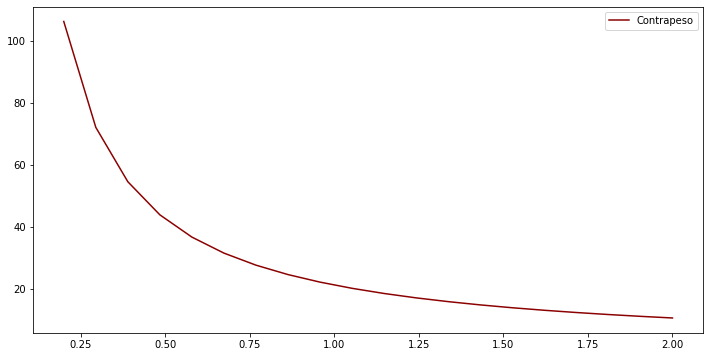

In [2]:
                                # Definición de las variables a usar 
    #Centros de gravedad 
x_3= 0.091 #x_3: Distancia del centro de gravedad del brazo en metros
x_4 = 0.306 #x_4: Distancia del centro de gravedad de la platina frontal en metros
x_2 = 0.915 # x_2: Distancia del centro de gravedad de la antena en metros

    #Pesos de los componentes
w_arm = 19.226*10 #Peso del brazo en Newtons
w_pl = 16.905*10 #Peso de la platina frontal en Newtons
w_ant = 44.572*10


x_1, w_cw = sp.var( 'x_1 w_cw')

My = w_ant*x_2 - 2*w_arm*x_3 + w_pl*x_4 - 2*w_cw*x_1

#Primera solución si x_1 = 1m
#My = My.subs(x_1,x_sol)
CWeight = sp.solve(My,w_cw, list = True)
CW = sp.lambdify(x_1,CWeight[0],"numpy")
x_sol = np.linspace(0.2,2,20)
CW_sol = CW(x_sol)/10
# print("--------------------------Contrapeso necesario------------------------")
# for i in range(len(x_sol)):
#    print("------------------------------------------------------","\n",
#        "Contrapeso: ",CW_sol[i], " Kg","\n",
#         "Distancia del contrapeso: ", x_sol[i], " metros")

fig = plt.figure(figsize=(12,6))
ax = plt.subplot()
ax.plot(x_sol,CW_sol,label = 'Contrapeso',color = 'darkred')
ax.legend()
plt.show()


Ecuación para contrapesos cuadrados:  2.46913580246914e-6*w_cw*x_1**2 + 1.85185185185185e-8*w_cw - 0.000365467527259259 
 Ecuación para contrapesos en forma de disco:  2.46913580246914e-6*w_cw*x_1**2 + 4.93827160493827e-8*w_cw - 0.000365467527259259 
 Ecuación para contrapesos semicilindrica:  2.46913580246914e-6*w_cw*x_1**2 + 3.80658436213992e-8*w_cw - 0.000365467527259259


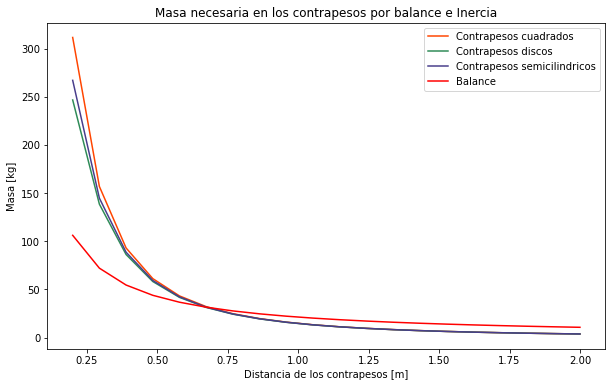

In [3]:

                                        #Inercias del sistema 
#Inertia Ratio deseable 
I_r =6.7
#Datos de la transmision
eta_red = 0.9 #Eficiencia de la reducción
N_pl_red = 100 #Reducción planetaria
N_worm_red = 3 #Segunda reducción por engranajes
N_red = N_pl_red*N_worm_red 
I_red = 0.00063
J_motor = 0.00027
#Se realiza el cálculo del momento de inercia respecto al eje de elevación según el contrapeso obtenido  
Ant_yy = 25.409
Arm_yy = 1.170
Pla_yy = 0.099 


    #Inercias de los diferentes componentes en el eje de elevación
Iant_o = Ant_yy + (w_ant/10)*(x_2**2)
Iarm_o = Arm_yy + 2*(w_arm/10)*(x_3**2)
Ipl_o = Pla_yy +(w_pl/10)*(x_4**2)


 
Icw_y_sqr, Icw_y_disk, Icw_y_cil = sp.var('Icw_y_sqr Icw_y_disk Icw_y_cil')
Icw_o_sqr, Icw_o_disk, Icw_o_cil = sp.var('Icw_o_sqr Icw_o_disk Icw_o_cil')


#Inercia de lo contrapesos 
#Si los contrapesos son cuadrados
a = 0.3
b = 0.3
Icw_y_sqr = (1/12)*(w_cw/10)*(a**2 + b**2)
Icw_o_sqr = Icw_y_sqr + 2*(w_cw/10)*x_1**2
#Si los contrapesos son thin disk
R = 0.4
Icw_y_disk = (1/4)*(w_cw/10)*R**2
Icw_o_disk = Icw_y_disk + 2*(w_cw/10)*x_1**2
#Si los contrapesos son semicilindricos
R = 0.2
L = 0.5
Icw_y_cil = (1/12)*(w_cw/10)*(3*R**2 + L**2)
Icw_o_cil = Icw_y_cil + 2*(w_cw/10)*x_1**2
#Inercia total del sistema
Iy_o_sqr = (1/(eta_red*(N_red**2)))*(Iant_o + Iarm_o + Ipl_o + Icw_o_sqr) + I_red - I_r*J_motor
Iy_o_disk = (1/(eta_red*(N_red**2)))*(Iant_o + Iarm_o + Ipl_o + Icw_o_disk) + I_red - I_r*J_motor
Iy_o_cil = (1/(eta_red*(N_red**2)))*(Iant_o + Iarm_o + Ipl_o + Icw_o_cil) + I_red - I_r*J_motor


print("Ecuación para contrapesos cuadrados: ",Iy_o_sqr,"\n",
      "Ecuación para contrapesos en forma de disco: ",Iy_o_disk,"\n",
      "Ecuación para contrapesos semicilindrica: ",Iy_o_cil)

#Solucion de las ecuaciones
CWeight_sqr = sp.solve(Iy_o_sqr,w_cw, list = True)
CW_sqr = sp.lambdify(x_1,CWeight_sqr[0],"numpy")
CW_sol_sqr = CW_sqr(x_sol)/10

CWeight_disk = sp.solve(Iy_o_disk,w_cw, list = True)
CW_disk = sp.lambdify(x_1,CWeight_disk[0],"numpy")
CW_sol_disk = CW_disk(x_sol)/10

CWeight_cil = sp.solve(Iy_o_cil,w_cw, list = True)
CW_cil = sp.lambdify(x_1,CWeight_cil[0],"numpy")
CW_sol_cil = CW_cil(x_sol)/10

fig = plt.figure(figsize=(10,6))
ax = plt.subplot()
ax.plot(x_sol,CW_sol_sqr,color = 'orangered', label = 'Contrapesos cuadrados')
ax.plot(x_sol,CW_sol_disk,color = 'seagreen', label = 'Contrapesos discos')
ax.plot(x_sol,CW_sol_cil,color = 'darkslateblue', label = 'Contrapesos semicilindricos')
ax.plot(x_sol,CW_sol,label = 'Balance',color = 'red')
ax.set_title("Masa necesaria en los contrapesos por balance e Inercia")
ax.set_ylabel("Masa [kg]")
ax.set_xlabel("Distancia de los contrapesos [m]")
ax.legend()
plt.savefig('Diseño_contrapesos.jpg')



In [4]:
                #Se calcula la distancia para cada tipo de geometria
#Si los contrapesos son rectangulares
x_rect = CWeight_sqr[0] - CWeight[0]
x_rect_sol = sp.solve(x_rect,x_1)
x_rect_sol

#Si los contrapesos son discos
x_disk = CWeight_disk[0] - CWeight[0]
x_disk_sol = sp.solve(x_disk,x_1)
x_disk_sol

#Si los contrapesos son discos
x_cil = CWeight_cil[0] - CWeight[0]
x_cil_sol = sp.solve(x_cil,x_1)
x_cil_sol
print("----------------Distancias para ubicar los contrapesos según la geometria---------------","\n",
      "Para contrapesos rectangulares: ","\n",
      "Distancia: ",x_rect_sol[1],"\n",
      "Peso: ", CW(np.array(x_rect_sol[1]))/10,"\n",
      "---------------------------------------------","\n",
     "Para contrapesos discos: ","\n",
      "Distancia: ",x_disk_sol[1],"\n",
      "Peso: ", CW(np.array(x_disk_sol[1]))/10,"\n", 
      "---------------------------------------------","\n",
      "Para contrapesos cilindricos: ","\n",
      "Distancia: ",x_cil_sol[1],"\n",
      "Peso: ", CW(np.array(x_cil_sol[1]))/10,"\n", 
      
     )

----------------Distancias para ubicar los contrapesos según la geometria--------------- 
 Para contrapesos rectangulares:  
 Distancia:  0.686312670257047 
 Peso:  30.9313668827492 
 --------------------------------------------- 
 Para contrapesos discos:  
 Distancia:  0.667267654110544 
 Peso:  31.8142035946540 
 --------------------------------------------- 
 Para contrapesos cilindricos:  
 Distancia:  0.674380134628286 
 Peso:  31.4786689434455 



In [5]:
                        #Comprobación del modelo CAD
CW_kg = 24.398*10
Cw_distance = sp.solve(My,x_1, list = True)
x1_sol = Cw_distance[0].subs(w_cw,CW_kg)
x1_sol
Iyy = Iy_o_sqr.subs(x_1,x1_sol)
Iyy = Iyy.subs(w_cw,CW_kg)
Iy_el = Iyy + (I_r*J_motor*eta_red*(N_red**2))
print("Ratio Inertia es: ",Iy_el/(eta_red*(N_red**2)*J_motor))
print("A una distancia de: ",x1_sol)


Ratio Inertia es:  6.70000434943751
A una distancia de:  0.870095458644151


In [13]:
                        #Comprobación del modelo CAD
N_worm_red = 1.5
N_red = N_pl_red*N_worm_red 

Iy_o_sqr = (1/(eta_red*(N_red**2)))*(Iant_o + Iarm_o + Ipl_o + Icw_o_sqr) + I_red - I_r*J_motor


x1 = 0.592
Cw_weight = sp.solve(My,w_cw, list = True)
cw_sol = Cw_weight[0].subs(x_1,x1)
cw_sol
Iyy = Iy_o_sqr.subs(w_cw,cw_sol)
Iyy = Iyy.subs(x_1,x1)
Iy_el = Iyy + (I_r*J_motor*eta_red*(N_red**2))
print("Ratio Inertia es: ",Iy_el/(eta_red*(N_red**2)*J_motor))
print("El peso es:", cw_sol/10)

Ratio Inertia es:  6.70061141462143
El peso es: 35.8591030405405
